# **Automatidata project**
**Course 6 - The Nuts and bolts of machine learning**

# Course 6 End-of-course project: Build a machine learning model

This project uses tree-based modeling techniques to predict on a binary target class.  
<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

*This project is split into three parts:*

**Part 1:** Ethical considerations 
* Consider the ethical implications of the request 

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

## PACE: Plan 
In this stage, consider the following questions:

1.   **What are you being asked to do?**  
      Predict if a customer will not leave a tip.

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**  
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't)?  
      Drivers may take rides that they believe will leave a tip, but the rider ends up not leaving one. This negatively impacts the driver.

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?  
      Riders who are unlikely to leave a tip according to the model may have difficulties getting a ride. This leads to rider dissatisfaction.

3.   **Do the benefits of such a model outweigh the potential problems?**  
      Drivers will be disincentivized from picking up people who don't tip. This is problematic for the company.

4.   **Would you proceed with the request to build this model? Why or why not?**  
      No, we could adjust our goal and create a different type of model (given that it's approved by stakeholders).

Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous&mdash;those who will tip 20% or more? Consider the following questions:

1.  **What features do you need to make this prediction?**  
    We have or can create times, dates, pick up and drop off locations, estimated fares, and payment method.
    
2.  **What would be the target variable?**  
    A new column that predicts generous tippers (>20% of total).

3.  **What metric should you use to evaluate your model? Do you have enough information to decide this now?**  
    It's early to tell which metric is most appropriate, but F1, precision, recall, and AUROC come to mind for classification.

### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Prevent Juptyer from truncating columns
pd.set_option('display.max_columns', None)

# Import metrics, hyperparameter tuning, and cross-validation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Model imports
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# The function that helps plot feature importance 
from xgboost import plot_importance

# Module to save models
import pickle

print("Imports completed")

Imports completed


In [2]:
# Read the data
df0 = pd.read_csv('TLC_Taxi_data.csv')
print("Data loaded successfully")
df0.head(5)

Data loaded successfully


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


## PACE: **Analyze**

### **Task 2. Feature engineering**

You have already prepared much of this data and performed exploratory data analysis (EDA) in previous courses. 

Call `info()` on the dataframe.

In [3]:
# Save a copy of original
df1 = df0.copy()

# Display the dataset's shape
print(df1.shape)

# Display basic info about the dataset
df1.info()

(22699, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  flo

You know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card. 

Copy `df0` and assign the result to a variable called `df1`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [4]:
# Filter df1 to include credit card payment trips
df1 = df1[df1['payment_type']==1]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = /frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [5]:
# Create tip % col
df1['tip_percent'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [6]:
df1['generous'] = (df1['tip_percent']>=.20)
df1['generous'] = df1['generous'].astype(int)

##### **Features**

Which columns are obviously unpredictive of tip percentage? Refer to the data dictionary.

Drop `Unnamed: 0` and `store_and_fwd_flag` columns. Assign the result back to `df11`.

In [7]:
# Drop 'Unnamed: 0' col and 'store_and_fwd_flag' col
df1 = df1.drop(['Unnamed: 0', 'store_and_fwd_flag'], axis=1)

Next, you're going to be working with the pickup and dropoff columns. To do this, you'll need to import the `datetime` module. Import this module as `dt`. 

Then, convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to the datetime class.

In [8]:
df1[['tpep_pickup_datetime', 'tpep_dropoff_datetime']] = df1[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].apply(pd.to_datetime)


Create a new column called `duration`, which captures the time elapsed from pickup to dropoff.

1.  Subtract `tpep_pickup_datetime` from `tpep_dropoff_datetime` and assign the result to a new column called `duration`.
2.  Convert the `duration` column to seconds. 

In [9]:
df1['duration'] = (df1['tpep_dropoff_datetime'] - df1['tpep_pickup_datetime']).dt.total_seconds()

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [10]:
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)

To do this, first create the four columns. For now, each new column should contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [11]:
# I deleted the tutorial's extra steps since each column can be generated using a single line
df1['am_rush'] = (df1['tpep_pickup_datetime'].dt.hour >= 6) & (df1['tpep_pickup_datetime'].dt.hour < 10)
df1['daytime'] = (df1['tpep_pickup_datetime'].dt.hour >= 10) & (df1['tpep_pickup_datetime'].dt.hour < 16)
df1['pm_rush'] = (df1['tpep_pickup_datetime'].dt.hour >= 16) & (df1['tpep_pickup_datetime'].dt.hour < 20)
df1['nighttime'] = (df1['tpep_pickup_datetime'].dt.hour >= 20) | (df1['tpep_pickup_datetime'].dt.hour < 6)

Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [12]:
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

Because you have encoded much of the information contained in the pickup and dropoff columns into new columns, you can drop them for modeling. 

1. Drop the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns and reassign the result back to `df11`.

In [13]:
df1 = df1.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

Examine the first five rows of your dataframe.

In [14]:
df1.head(5)

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_percent,generous,duration,day,am_rush,daytime,pm_rush,nighttime,month
0,2,6,3.34,1,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0.200000,1,844.0,saturday,True,False,False,False,mar
1,1,1,1.80,1,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,0.238095,1,1590.0,tuesday,False,True,False,False,apr
2,1,1,1.00,1,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,0.198630,0,432.0,friday,True,False,False,False,dec
3,2,1,3.70,1,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,0.300000,1,1815.0,sunday,False,True,False,False,may
5,2,6,2.30,1,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0.200000,1,480.0,saturday,False,False,False,True,mar


Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_string` to string.


In [15]:
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID']

for col in cols_to_str:
    df1[col] = df1[col].astype(str)

The `VendorID` column is also a numerical column that contains categorical information (which taxi cab company picked up the passenger). The values are all 1 or 2. 

1. Convert this to binary by subtracting 1 from every value in the column.

In [16]:
df1['VendorID'] = df1['VendorID'] - 1

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df12`. Don't use the `drop_first` parameter.


In [17]:
df2 = pd.get_dummies(df1)

Finally, drop the columns that are constant or that contain information that would be a proxy for our target variable. For example, `total_amount` contains tip amount, and therefore tip percentage, if used with `fare_amount`. And `mta_tax` is $0.50 99.6% of the time, so it's not adding any predictive signal to the model.

1. Drop the following features: `payment_type`, `mta_tax`, `tip_amount`, `total_amount`, and `tip_percent`. Assign the results to a new dataframe called `df3`. 

In [18]:
df3 = df2.drop(['payment_type', 'mta_tax', 'tip_amount', 'total_amount', 'tip_percent'], axis=1)

##### **Evaluation metric**

Before modeling, you must decide on an evaluation metric. 

1. Examine the class balance of your target variable. 

In [19]:
df3['generous'].value_counts()

0    9944
1    5321
Name: generous, dtype: int64

Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so. 

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receiving one.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more.

**Since your client represents taxi drivers, use a metric that evaluates false positives. Which metric is this?**

Precision gives us true positives which is the complement of false positives.

## PACE: **Construct**

### **Task 3. Modeling**

##### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [20]:
# Choose dependent column
y = df3['generous']

# Choose independent columns
X = df3.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` should be set to `'precision'`.<font/>
</details>
 


In [21]:
# Create the model
rf_classifier =  RandomForestClassifier(random_state=0)

# Set the parameters
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Set the scoring measures
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate GridSearchCV with above specified arguments
gs = GridSearchCV(estimator=rf_classifier, param_grid=cv_params, scoring=scoring, cv=4, n_jobs=-1, refit='precision')

Now fit the model to the training data.

In [22]:
# Pickle methods to save the model
path = ''

def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [23]:
# Takes about 40 minutes to complete using 6 i5 cores at 3.9ghz. 
%%time
print("Training Classifier...")
gs.fit(X_train, y_train)
print("Classifier trained. \nWriting to Disk...")
write_pickle(path, gs, 'taxi_gs1')
print("Classifier saved.")

Training Classifier...
Classifier trained. 
Writing to Disk...
Classifier saved.


Examine the best average score across all the validation folds and the best combination of hyperparameters.

In [27]:
gs1 = read_pickle(path, 'taxi_gs1')
print("Precision:", gs1.best_score_)
print("Best Parameters:", gs1.best_params_)

Precision: 0.6799871255296763
Best Parameters: {'max_depth': 5, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}


Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [29]:
def make_results(model_name:str, model_object, metric:str):
  '''
  Arguments:
    model_name (string): model label for output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy
  
  Returns a pandas DataFrame with the F1, recall, precision, and accuracy scores
  for the model with the best mean 'metric' score across all validation folds.  
  '''

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
  metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

  # Get all the results from the CV and put them in a df1
  cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df1 with the max(metric) score
  best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
  f1 = best_estimator_results.mean_test_f1
  recall = best_estimator_results.mean_test_recall
  precision = best_estimator_results.mean_test_precision
  accuracy = best_estimator_results.mean_test_accuracy
  
  # Create table of results
  table = pd.DataFrame()
  table = table.append({'Model': model_name,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        },
                        ignore_index=True
                       )
  
  return table

Call `make_results()` on the GridSearch object.

In [41]:
import warnings

# Ignore FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

results = make_results('random forest 1: precision', gs1, 'precision')
print(results)

                        Model  Precision    Recall        F1  Accuracy
0  random forest 1: precision   0.679987  0.258632  0.374542  0.698985


The precision seems satisfactory, but not great. The other scores are very bad. 

A model with such low F1 and recall scores is not good enough. Try retuning the model to select based on F1 score instead. Consider adjusting the hyperparameters that you try based on the results of the above model. 

In [32]:
# Create the model
rf_classifier = RandomForestClassifier(random_state=0)

# Set the parameters
cv_params = {'max_depth': [5, 6, 7], 
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [300],
             }  

# Set the scoring measures
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate GridSearchCV with above specified arguments
gs2 = GridSearchCV(estimator=rf_classifier, param_grid=cv_params, scoring=scoring, cv=4, n_jobs=-1, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [33]:
%%time
print("Training Classifier...")
gs2.fit(X_train, y_train)
print("Classifier trained. \nWriting to Disk...")
write_pickle(path, gs2, 'taxi_gs2')
print("Classifier saved.")

Training Classifier...
Classifier trained. 
Writing to Disk...
Classifier saved.
CPU times: total: 6.98 s
Wall time: 2min 27s


Get the best score and parameters from this model.

In [35]:
gs2 = read_pickle(path, 'taxi_gs2')
print("Precision:", gs2.best_score_)
print("Best Parameters:", gs2.best_params_)

Precision: 0.43799269763587406
Best Parameters: {'max_depth': 7, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [42]:
results = make_results('random forest 2: F1', gs2, 'f1')
results

,Model,Precision,Recall,F1,Accuracy
0,random forest 2: F1,0.660154,0.327931,0.437993,0.7066


There was a modest improvement in both F1 and recall scores, but these results still are not good enough to deploy the model.

In [37]:
# Make predicitons on the X_test set
preds = gs2.best_estimator_.predict(X_test)

Complete the below `get_test_scores()` function you will use to output the scores of the model on the test data. 

In [38]:
def get_test_scores(model_name:str, preds, y_test_data):
  '''
  Generate a table of test scores.

  In: 
    model_name (string): model label for output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

  Out: 
    table: A Pandas DataFrame with precision, recall, f1, and accuracy scores
  '''
  accuracy = round(accuracy_score(y_test_data, preds), 3)
  precision = round(precision_score(y_test_data, preds), 3)
  recall = round(recall_score(y_test_data, preds), 3)
  f1 = round(f1_score(y_test_data, preds), 3)

  table = pd.DataFrame({'model': [model_name],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
  return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_cv2_test_scores`.
2. Call `rf_cv2_test_scores` to output the results.

In [43]:
# Get scores on test data
rf_cv2_test_scores = get_test_scores('random forest: f1', preds, y_test)
rf_cv2_test_scores

,model,precision,recall,f1,accuracy
0,random forest: f1,0.708,0.336,0.455,0.72


**How do your test results compare to your validation results?** 

All scores had a marginal increase when using the validation set.

##### **XGBoost**

 Try to improve your scores using an XGBoost model. 

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [46]:
# Create the model
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Set the parameters
cv_params = {'max_depth': [4,8,12], 
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Set the scoring measures
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate GridSearchCV with above specified arguments
xgb_gs1 = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring, cv=4, n_jobs=-1, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [47]:
%%time
print("Training Classifier...")
xgb_gs1.fit(X_train, y_train)
print("Classifier trained. \nWriting to Disk...")
write_pickle(path, xgb_gs1, 'taxi_xgb_gs1')
print("Classifier saved.")

Training Classifier...
Classifier trained. 
Writing to Disk...
Classifier saved.
CPU times: total: 1min 34s
Wall time: 9min 23s


Get the best score and parameters from this model.

In [48]:
xgb_gs1 = read_pickle(path, 'taxi_xgb_gs1')
print("Precision:", xgb_gs1.best_score_)
print("Best Parameters:", xgb_gs1.best_params_)

Precision: 0.543194887763791
Best Parameters: {'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 300}


Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [49]:
results = make_results('XGBoost 1: f1', xgb_gs1, 'f1')
results

,Model,Precision,Recall,F1,Accuracy
0,XGBoost 1: f1,0.662924,0.460423,0.543195,0.730102


In [51]:
preds = xgb_gs1.best_estimator_.predict(X_test)

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_cv_test_scores`.
2. Call `xgb_cv_test_scores` to output the results. 

In [52]:
xgb_cv_test_scores = get_test_scores('XGBoost 1: f1', preds, y_test)
xgb_cv_test_scores

,model,precision,recall,f1,accuracy
0,XGBoost 1: f1,0.689,0.477,0.563,0.743


**Compare these scores to the random forest test scores. What do you notice? Which model would you choose?**


While the precision went down slightly, the recall and f1 scores increased dramatically. Accuracy also had a slight increase. XGBoost is the clear stronger model.

Plot a confusion matrix of the model's predictions on the test data.

In [57]:
cm = confusion_matrix(y_test, preds, labels=xgb_gs1.classes_)
cm_df = pd.DataFrame(cm)
cm_df.index.name = 'True Label'
cm_df.columns.name = 'Predicted Label'
cm_df

Predicted Label,0,1
True Label,,
0,1760,229
1,557,507


**What type of errors are more common for your model?**

False negatives are more common, about 2.5x the amount of false positives (type II error).

##### **Feature importance**

Use the `plot_importance` function to inspect the top 10 most important features of your final model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

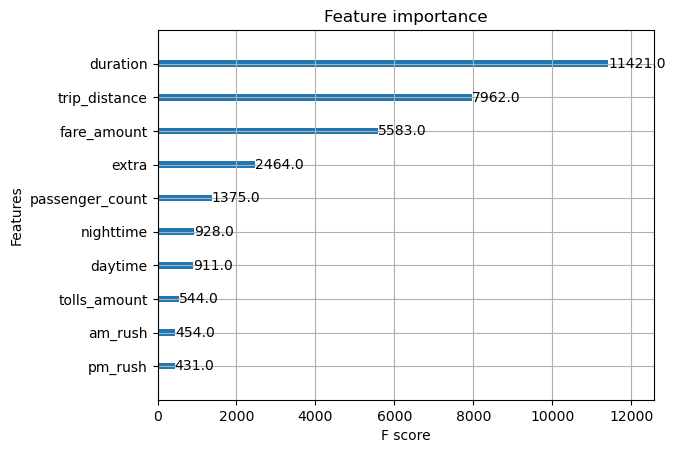

In [58]:
plot_importance(xgb_gs1.best_estimator_, max_num_features=10)

## PACE: **Execute**

### **Task 4. Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**  
    The model is not incredibly accurate. With strong enough metrics it could surely be useful, but this should be tested in the field before becoming policy.    

2. **What was your model doing? Can you explain how it was making predictions?**   
    XGBoost generally considered to be more on the blackbox end of algorithms. From the last graph, it is clear that duration, trip_distance, and fare_amount are the best predictors, but how they affect the final prediction is unclear.    

3. **Are there new features that you can engineer that might improve model performance?**   
    We can separate trip_distance into multiple bins like we did with time of day. We could also try to capture how close a fare amount is to a round number.    
4. **What features would you want to have that would likely improve the performance of your model?**   
    Cash tips were not recorded in this dataset but would be very useful. Past tips from the customer would also be a good predictor.    
    
  Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion. 